## Imports

In [1]:
from __future__ import annotations

from copy import deepcopy
import random; random.seed(42)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw, ImageColor
import cv2

import tensorflow as tf; tf.random.set_seed(42)
from tensorflow import keras

from keras.preprocessing.image import ImageDataGenerator

from keras.models import Sequential, Functional, Model
from keras.layers import Dense, Flatten, BatchNormalization, Dropout, Conv2D, MaxPooling2D, Input
from keras.layers import ReLU, ELU
from keras.layers.merging import concatenate
from keras.activations import relu, elu, sigmoid, softmax, linear
from keras.losses import CategoricalCrossentropy
from keras.optimizers import Adam, SGD
from keras.metrics import accuracy

device = tf.config.list_physical_devices('GPU')[0]
# tf.config.experimental.set_memory_growth(device, True)

## Helper Functions & Classes

In [2]:
def visualize(X: np.ndarray, y: np.ndarray, nrows: int, ncols: int, class_names: list[str] = None, img_width: float = 1.5, img_height: float = 1.5) -> plt.Figure:
    # plt OOP setup
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols)
    fig.set_size_inches(img_width * ncols, img_height * nrows)

    # get samples from dataset
    sample_idxs = random.sample(range(len(X)), nrows * ncols)
    X_samples = X[sample_idxs]
    y_samples = y[sample_idxs]

    # plot images
    for i in range(nrows * ncols):
        axes.flat[i].set_title(y_samples[i][0] if class_names is None else class_names[y_samples[i][0]])
        axes.flat[i].set_axis_off()
        axes.flat[i].imshow(X_samples[i])

    return fig


## Load Dataset

X_train: (50000, 32, 32, 3) | y_train: (50000, 1)
X_test : (10000, 32, 32, 3) | y_test : (10000, 1)


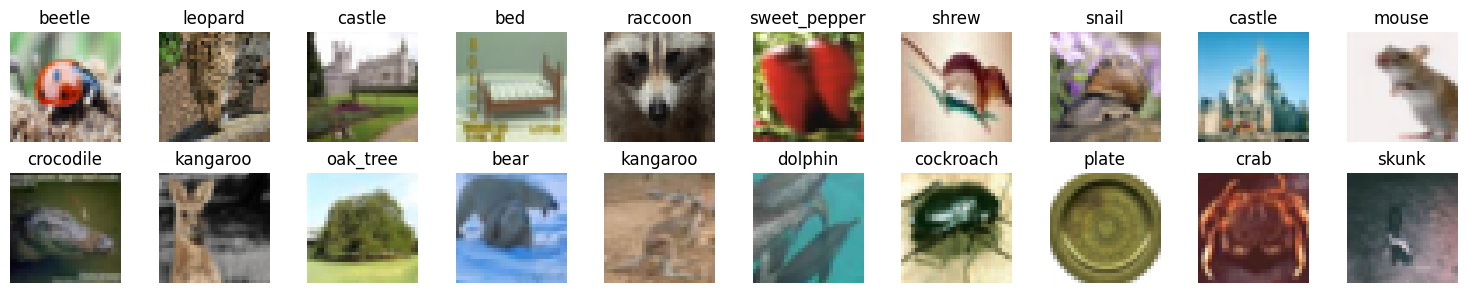

In [3]:
# load data from keras
(X_train_, y_train_), (X_test_, y_test_) = tf.keras.datasets.cifar100.load_data(label_mode="fine")
print(f'X_train: {X_train_.shape} | y_train: {y_train_.shape}')
print(f'X_test : {X_test_.shape} | y_test : {y_test_.shape}')

# onehot encode targets
y_train = keras.utils.to_categorical(y_train_)
y_test = keras.utils.to_categorical(y_test_)

# scale data values to between 0 and 1
X_train = X_train_ / 255
X_test = X_test_ / 255

# shuffle training dataset
shuffled_indexes_train, shuffled_indexes_test = list(range(len(X_train))), list(range(len(X_test)))
random.shuffle(shuffled_indexes_train)
random.shuffle(shuffled_indexes_test)

# X_train, y_train = X_train[shuffled_indexes_train], y_train[shuffled_indexes_train]
# X_test, y_test = X_test[shuffled_indexes_test], y_test[shuffled_indexes_test]

# class names from https://gist.github.com/adam-dziedzic/4322df7fc26a1e75bee3b355b10e30bc
class_names = ['apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 'bicycle', 
               'bottle', 'bowl', 'boy', 'bridge', 'bus', 'butterfly', 'camel', 'can', 'castle', 'caterpillar', 
               'cattle', 'chair', 'chimpanzee', 'clock', 'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 
               'cup', 'dinosaur', 'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster', 'house', 
               'kangaroo', 'computer_keyboard', 'lamp', 'lawn_mower', 'leopard', 'lion', 'lizard', 'lobster', 
               'man', 'maple_tree', 'motorcycle', 'mountain', 'mouse', 'mushroom', 'oak_tree', 'orange', 'orchid', 
               'otter', 'palm_tree', 'pear', 'pickup_truck', 'pine_tree', 'plain', 'plate', 'poppy', 'porcupine', 
               'possum', 'rabbit', 'raccoon', 'ray', 'road', 'rocket', 'rose', 'sea', 'seal', 'shark', 'shrew', 
               'skunk', 'skyscraper', 'snail', 'snake', 'spider', 'squirrel', 'streetcar', 'sunflower', 'sweet_pepper', 
               'table', 'tank', 'telephone', 'television', 'tiger', 'tractor', 'train', 'trout', 'tulip', 'turtle', 
               'wardrobe', 'whale', 'willow_tree', 'wolf', 'woman', 'worm']

# dataset variables
_, img_width, img_height, img_channels = X_train_.shape
n_classes = len(class_names)

visualize(X_train_, y_train_, 2, 10, class_names=class_names)
plt.tight_layout()

## **Baseline** CNN Model on **Base** Dataset

In [4]:
run_cell = True
fit_model = False

if run_cell:
    CIFAR100ModelV0 = Sequential([
        Conv2D(64, kernel_size=(4, 4), padding='same', activation=elu, input_shape=(img_width, img_height, img_channels)),
        MaxPooling2D(pool_size=(4, 4)),

        Conv2D(64, kernel_size=(4, 4), padding='same', activation=elu),
        MaxPooling2D(pool_size=(2, 2)),

        Conv2D(64, kernel_size=(4, 4), padding='same', activation=elu),
        MaxPooling2D(pool_size=(2, 2)),

        Conv2D(64, kernel_size=(4, 4), padding='same', activation=elu),
        MaxPooling2D(pool_size=(2, 2)),

        Flatten(),
        BatchNormalization(),
        Dense(256, activation=elu),
        Dropout(0.4),

        Dense(n_classes, activation=softmax)
    ])
    CIFAR100ModelV0.compile(optimizer=Adam(0.001), loss=CategoricalCrossentropy(), metrics=['accuracy'])

if fit_model:
    CIFAR100ModelV0.fit(X_train, y_train, batch_size=128, epochs=50, validation_data=(X_test, y_test))

## Data Augmentation
Each class has $50000 / 100 = 500$ training samples to fit on, which can be too little to get a good model. 
Data augmentation can be used to artificially increase the dataset and provide more samples for the model to fit on and generalize better.

In [5]:
# data augmentation on existing data
datagen = ImageDataGenerator(rotation_range=40,
                             width_shift_range=0.2,
                             height_shift_range=0.2,
                             shear_range=0.2,
                             zoom_range=0.2,
                             horizontal_flip=True,
                             fill_mode='nearest')
data_flow = datagen.flow(X_train, y_train, batch_size=256, shuffle=True)

## Model Building
* **Attempt 01:** Expanding on the current baseline model, more and larger layers.
* **Attempt 02:** Passing the data through 4 of the baseline models using the keras `Functional API`.

In [9]:
CIFAR100ModelV1 = Sequential([
    Conv2D(64, kernel_size=(4, 4), padding='same', activation=elu, input_shape=(img_width, img_height, img_channels)),
    Conv2D(64, kernel_size=(4, 4), padding='same', activation=elu),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(64, kernel_size=(4, 4), padding='same', activation=elu),
    Conv2D(64, kernel_size=(4, 4), padding='same', activation=elu),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(64, kernel_size=(4, 4), padding='same', activation=elu),
    Conv2D(64, kernel_size=(4, 4), padding='same', activation=elu),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(64, kernel_size=(4, 4), padding='same', activation=elu),
    Conv2D(64, kernel_size=(4, 4), padding='same', activation=elu),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(64, kernel_size=(4, 4), padding='same', activation=elu),
    Conv2D(64, kernel_size=(4, 4), padding='same', activation=elu),
    MaxPooling2D(pool_size=(2, 2)),

    Flatten(),
    BatchNormalization(),
    Dense(64, activation=elu),
    Dense(128, activation=elu),
    Dropout(0.4),

    Dense(n_classes, activation=softmax)
])
CIFAR100ModelV1.compile(optimizer=Adam(0.01), loss=CategoricalCrossentropy(), metrics=['accuracy'])
CIFAR100ModelV1.fit(X_train, y_train, batch_size=128, epochs=25, validation_data=(X_test, y_test))

Epoch 1/25
391/391 [==============================] - 45s 108ms/step - loss: 4.3467 - accuracy: 0.0334 - val_loss: 8.8553 - val_accuracy: 0.0163
Epoch 2/25
391/391 [==============================] - 40s 103ms/step - loss: 4.0860 - accuracy: 0.0535 - val_loss: 4.7059 - val_accuracy: 0.0287
Epoch 3/25
391/391 [==============================] - 41s 104ms/step - loss: 3.9971 - accuracy: 0.0666 - val_loss: 8.5050 - val_accuracy: 0.0243
Epoch 4/25
391/391 [==============================] - 41s 104ms/step - loss: 3.9367 - accuracy: 0.0745 - val_loss: 4.6522 - val_accuracy: 0.0628
Epoch 5/25
391/391 [==============================] - 41s 105ms/step - loss: 3.8423 - accuracy: 0.0856 - val_loss: 5.1258 - val_accuracy: 0.0538
Epoch 6/25
391/391 [==============================] - 41s 104ms/step - loss: 3.7702 - accuracy: 0.0965 - val_loss: 3.9355 - val_accuracy: 0.0836
Epoch 7/25
391/391 [==============================] - ETA: 0s - loss: 3.7007 - accuracy: 0.1055

KeyboardInterrupt: 

In [8]:
CIFAR100ModelV1.fit(X_train, y_train, batch_size=128, epochs=75, validation_data=(X_test, y_test))

Epoch 1/75
391/391 [==============================] - 29s 73ms/step - loss: 2.7115 - accuracy: 0.2718 - val_loss: 3.0906 - val_accuracy: 0.2550
Epoch 2/75
391/391 [==============================] - 28s 73ms/step - loss: 2.6771 - accuracy: 0.2778 - val_loss: 2.6666 - val_accuracy: 0.3165
Epoch 3/75
391/391 [==============================] - 28s 73ms/step - loss: 2.6506 - accuracy: 0.2837 - val_loss: 2.6252 - val_accuracy: 0.3210
Epoch 4/75
391/391 [==============================] - 28s 73ms/step - loss: 2.6241 - accuracy: 0.2869 - val_loss: 2.9655 - val_accuracy: 0.2778
Epoch 5/75
391/391 [==============================] - 29s 73ms/step - loss: 2.6054 - accuracy: 0.2890 - val_loss: 2.9005 - val_accuracy: 0.2954
Epoch 6/75
391/391 [==============================] - 29s 73ms/step - loss: 2.5692 - accuracy: 0.2984 - val_loss: 3.0092 - val_accuracy: 0.3031
Epoch 7/75
391/391 [==============================] - 29s 73ms/step - loss: 2.5662 - accuracy: 0.2988 - val_loss: 2.6907 - val_accuracy:

KeyboardInterrupt: 

In [ ]:
# init baseline without the output
CIFAR100BaselineModels = [Sequential([
    Conv2D(64, kernel_size=(4, 4), padding='same', activation=elu),
    MaxPooling2D(pool_size=(4, 4)),
    BatchNormalization(),

    Conv2D(64, kernel_size=(4, 4), padding='same', activation=elu),
    MaxPooling2D(pool_size=(2, 2)),
    BatchNormalization(),

    Conv2D(64, kernel_size=(4, 4), padding='same', activation=elu),
    MaxPooling2D(pool_size=(2, 2)),
    BatchNormalization(),

    Conv2D(64, kernel_size=(4, 4), padding='same', activation=elu),
    MaxPooling2D(pool_size=(2, 2)),
    BatchNormalization(),

    Flatten(),
    BatchNormalization(),
    Dense(256, activation=elu),
    Dropout(0.4)
], name=f'squential_{i}') for i in range(4)]

# functional api
input_layer = Input(shape=(img_width, img_height, img_channels))

# 4x models
model_0 = CIFAR100BaselineModels[0](input_layer)
model_1 = CIFAR100BaselineModels[1](input_layer)
model_2 = CIFAR100BaselineModels[2](input_layer)
model_3 = CIFAR100BaselineModels[3](input_layer)

# output
merge = concatenate([model_0, model_1, model_2, model_3])
dense_1 = Dense(128, activation=elu)(merge)
dense_2 = Dense(128, activation=elu)(dense_1)
output_layer = Dense(n_classes, activation=softmax)(dense_2)

# compile
CIFAR100ModelV1 = Model(inputs=input_layer, outputs=output_layer)
CIFAR100ModelV1.compile(optimizer=Adam(0.01), loss=CategoricalCrossentropy(), metrics=['accuracy'])

In [ ]:
CIFAR100ModelV1.fit(X_train, y_train, batch_size=128, epochs=50, validation_data=(X_test, y_test))

Epoch 1/50
391/391 [==============================] - 23s 43ms/step - loss: 4.0299 - accuracy: 0.0717 - val_loss: 4.2229 - val_accuracy: 0.0576
Epoch 2/50
391/391 [==============================] - 16s 40ms/step - loss: 3.6205 - accuracy: 0.1279 - val_loss: 3.5179 - val_accuracy: 0.1402
Epoch 3/50
391/391 [==============================] - 16s 41ms/step - loss: 3.3868 - accuracy: 0.1703 - val_loss: 3.5893 - val_accuracy: 0.1553
Epoch 4/50
391/391 [==============================] - 26s 67ms/step - loss: 3.2062 - accuracy: 0.1982 - val_loss: 3.4833 - val_accuracy: 0.1803
Epoch 5/50
391/391 [==============================] - 48s 123ms/step - loss: 3.0337 - accuracy: 0.2311 - val_loss: 3.3060 - val_accuracy: 0.1945
Epoch 6/50
391/391 [==============================] - 48s 123ms/step - loss: 2.8881 - accuracy: 0.2561 - val_loss: 3.2283 - val_accuracy: 0.2170
Epoch 7/50
 82/391 [=====>........................] - ETA: 35s - loss: 2.7993 - accuracy: 0.2740

KeyboardInterrupt: 